In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from utilsCPD import *
import matplotlib.pyplot as plt
from SWCPD import BaseDetector as SWDCP


<Axes: >

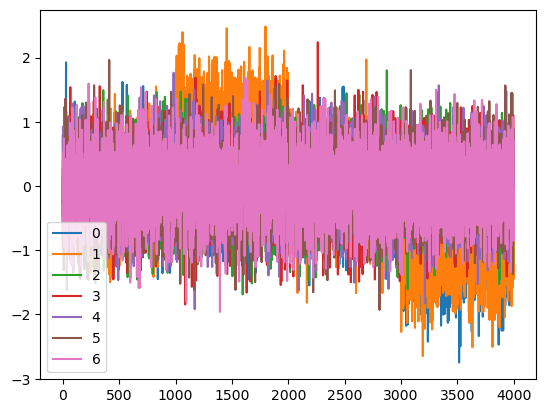

In [172]:
def make_dynamic_blobs(n_samples, base_center, n_clusters, varying_features, 
                       cluster_std=1.0, center_offset_range=(-5, 5), random_state=None):
    """
    Generate synthetic data with dynamic centers based on a base center and random offsets.
    
    Parameters:
        n_samples: int
            Total number of samples.
        base_center: array-like
            The center of the first cluster. Shape: (n_features,).
        n_clusters: int
            Number of clusters to generate.
        varying_features: list of int
            Indices of features that should vary across clusters.
        cluster_std: float
            Standard deviation of clusters.
        center_offset_range: tuple
            Range (min, max) for random uniform offsets added to the base center for varying features.
        random_state: int or None
            Random seed for reproducibility.
    
    Returns:
        X: ndarray of shape (n_samples, n_features)
            The generated samples.
        y: ndarray of shape (n_samples,)
            The integer labels for cluster membership.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    n_features = len(base_center)
    samples_per_cluster = n_samples // n_clusters
    remainder = n_samples % n_clusters

    # Generate cluster centers
    centers = [np.array(base_center)]
    for _ in range(1, n_clusters):
        new_center = centers[0].copy()  # Start with the base center
        for feature in varying_features:
            new_center[feature] += np.random.uniform(*center_offset_range)
        centers.append(new_center)
    centers = np.array(centers)
    
    # Generate points for each cluster
    X = []
    y = []
    for cluster_idx, center in enumerate(centers):
        cluster_size = samples_per_cluster + (1 if cluster_idx < remainder else 0)
        cluster_points = np.random.normal(
            loc=center,
            scale=cluster_std,
            size=(cluster_size, n_features)
        )
        X.append(cluster_points)
        y.extend([cluster_idx] * cluster_size)
    
    X = np.vstack(X)
    y = np.array(y)
    
    return X.astype(np.float32), y, centers

# Example Usage
base_center = [0, 0, 0,0,0,0,0]#,0,0,0,0]  # Base center for the first cluster
n_clusters = 4
n_samples = 4000
varying_features = [0,1]#, 1,4,5,6]  # Only the first two features vary
X, y, centers = make_dynamic_blobs(
    n_samples=n_samples, 
    base_center=base_center, 
    n_clusters=n_clusters, 
    varying_features=varying_features, 
    cluster_std=0.5, 
    center_offset_range=(-2, 2), 
    random_state=42
)

fig, ax = plt.subplots()
pd.DataFrame(X).plot(ax=ax)

In [176]:
pd.DataFrame(X).to_csv('SYN1.csv')

In [55]:
np.where(np.diff(y)!=0)[0]+1

X.astype(np.float32)

array([[ 1.5792128 ,  0.7674347 , -0.46947438],
       [ 0.54256004, -0.46341768, -0.46572974],
       [ 0.24196227, -1.9132802 , -1.7249179 ],
       ...,
       [-1.44751   , -1.7760859 ,  1.3641404 ],
       [-1.8747755 , -2.4294055 ,  0.1222975 ],
       [-1.456702  , -1.9511399 ,  0.04059169]], dtype=float32)

In [173]:
METRICS_SWD = {}
for id,i in enumerate(range(1)):
    print(id)
    METRICS_SWD[id]  = {}
    df, GroundTruth = X, np.where(np.diff(y)!=0)[0]+1
    print(GroundTruth)
    detector = SWDCP(data=df,window_length=100,max_history=100)
    print(detector.device)
    detector.process_dataloader(p=4,n_theta=1000)
    METRICS_SWD[id]['F1'] =f_measure({'0':GroundTruth},detector.change_points['loc'],margin=20)
    METRICS_SWD[id]['Covering'] = covering({'0':GroundTruth},detector.change_points['loc'],n_obs=df.shape[0])
    print(METRICS_SWD[id])

0
[1000 2000 3000]
cuda


  0%|          | 0/3901 [00:00<?, ?it/s]

 25%|██▍       | 965/3901 [00:02<00:06, 428.35it/s]

Change detected at: 1013 
Initiate new segment


 51%|█████     | 1983/3901 [00:04<00:04, 439.08it/s]

Change detected at: 2017 
Initiate new segment


 76%|███████▌  | 2959/3901 [00:06<00:02, 435.85it/s]

Change detected at: 3010 
Initiate new segment


100%|██████████| 3901/3901 [00:08<00:00, 433.98it/s]

Change detected at: 3936 
Initiate new segment
Change detected at: 3940 
Initiate new segment
{'F1': 0.8, 'Covering': 0.9642339082133498}


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='Time'>)

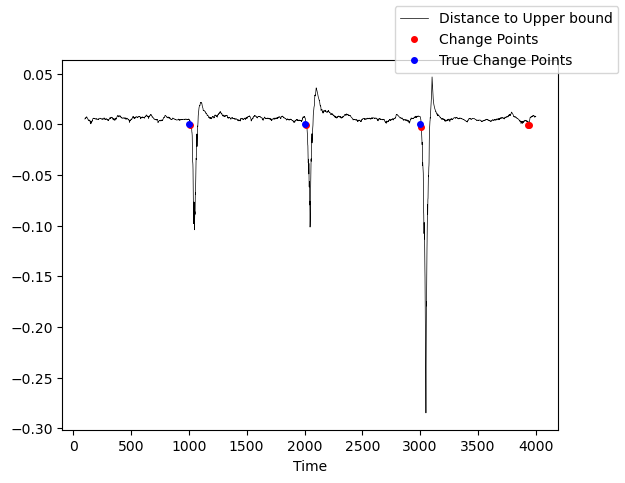

In [174]:
detector.plot(GroundTruth)

In [ ]:
from claspy.segmentation import BinaryClaSPSegmentation


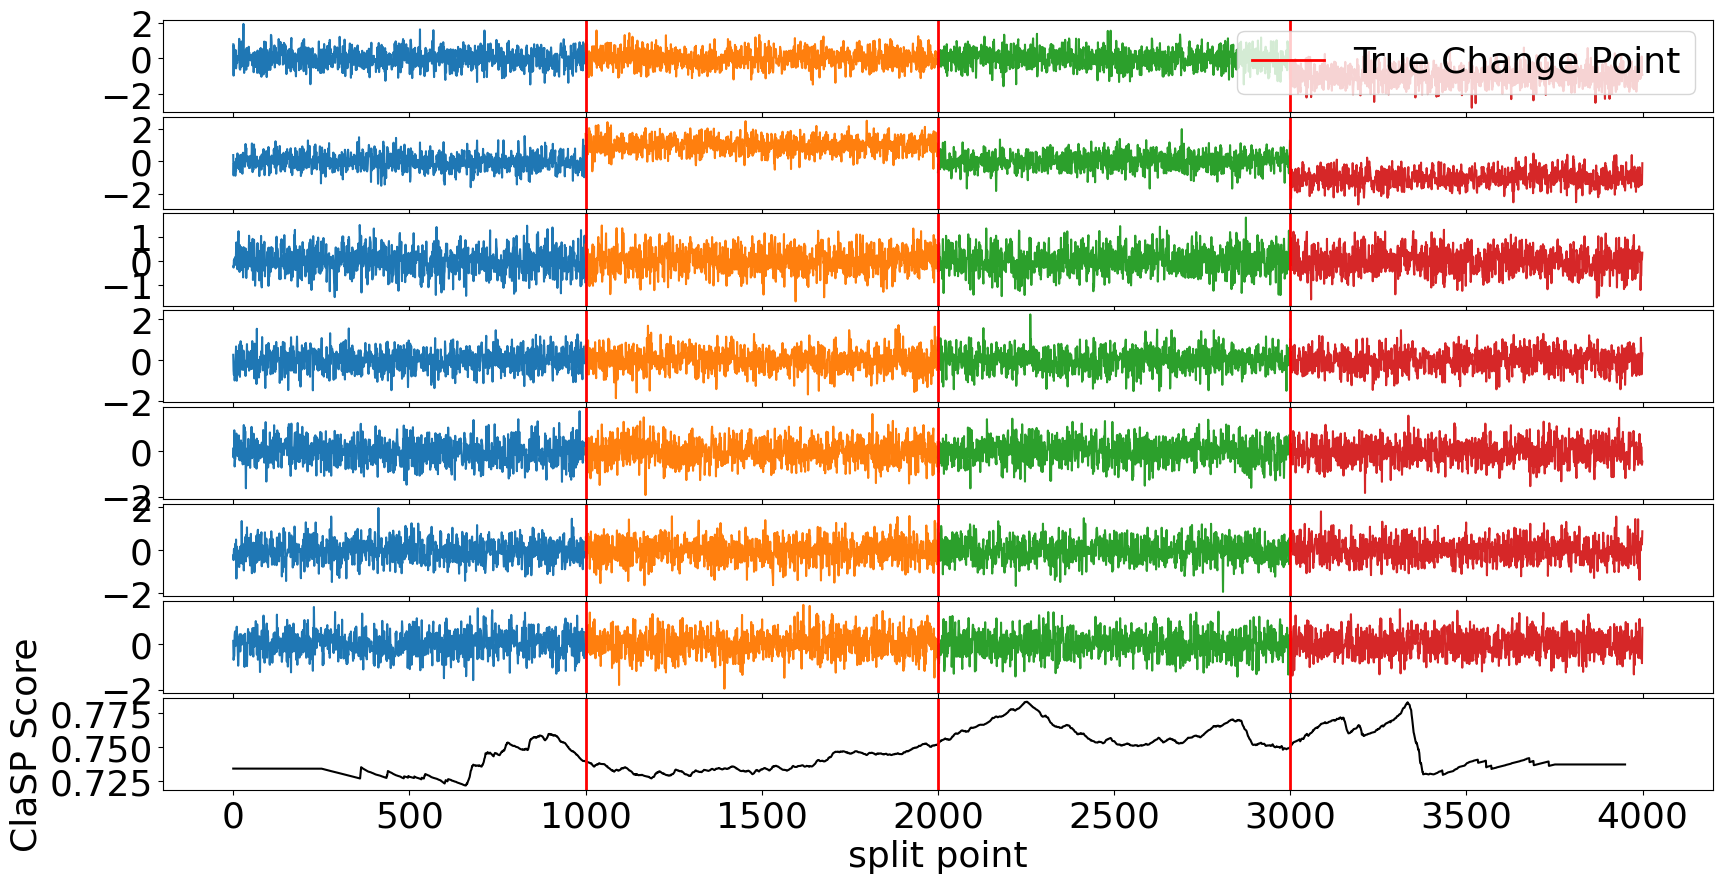

In [175]:
clasp = BinaryClaSPSegmentation(window_size=50,k_neighbours=3,n_segments=4).fit(X.astype(np.float64))
ax = clasp.plot(gt_cps=GroundTruth)